In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


In [3]:
df = pd.read_csv('/Users/dmitrybertnikov/Desktop/ds_learn/playgroundPORFOLIO/train.csv')
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
annual_income,29367.99,22108.02,49566.2,46858.25,25496.7
debt_to_income_ratio,0.084,0.166,0.097,0.065,0.053
credit_score,736,636,694,533,665
loan_amount,2528.42,4593.1,17005.15,4682.48,12184.43
interest_rate,13.67,12.92,9.76,16.1,10.21
gender,Female,Male,Male,Female,Male
marital_status,Single,Married,Single,Single,Married
education_level,High School,Master's,High School,High School,High School
employment_status,Self-employed,Employed,Employed,Employed,Employed


In [9]:
df.info(
    
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [10]:
df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


<Axes: title={'center': 'Распределение таргет переменной (loan_paid_back)'}, xlabel='loan_paid_back'>

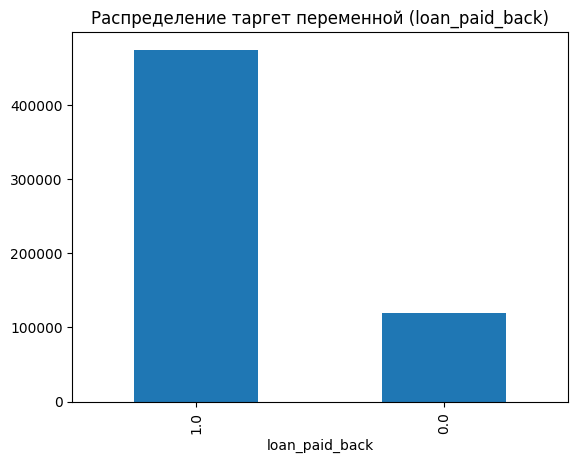

In [12]:
df['loan_paid_back'].value_counts().plot(
    kind='bar',
    title='Распределение таргет переменной (loan_paid_back)'
)


 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64

In [16]:
target = 'loan_paid_back'
numeric_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'loan_amount',
    'interest_rate',
    'credit_score'
]

categorical_cols = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

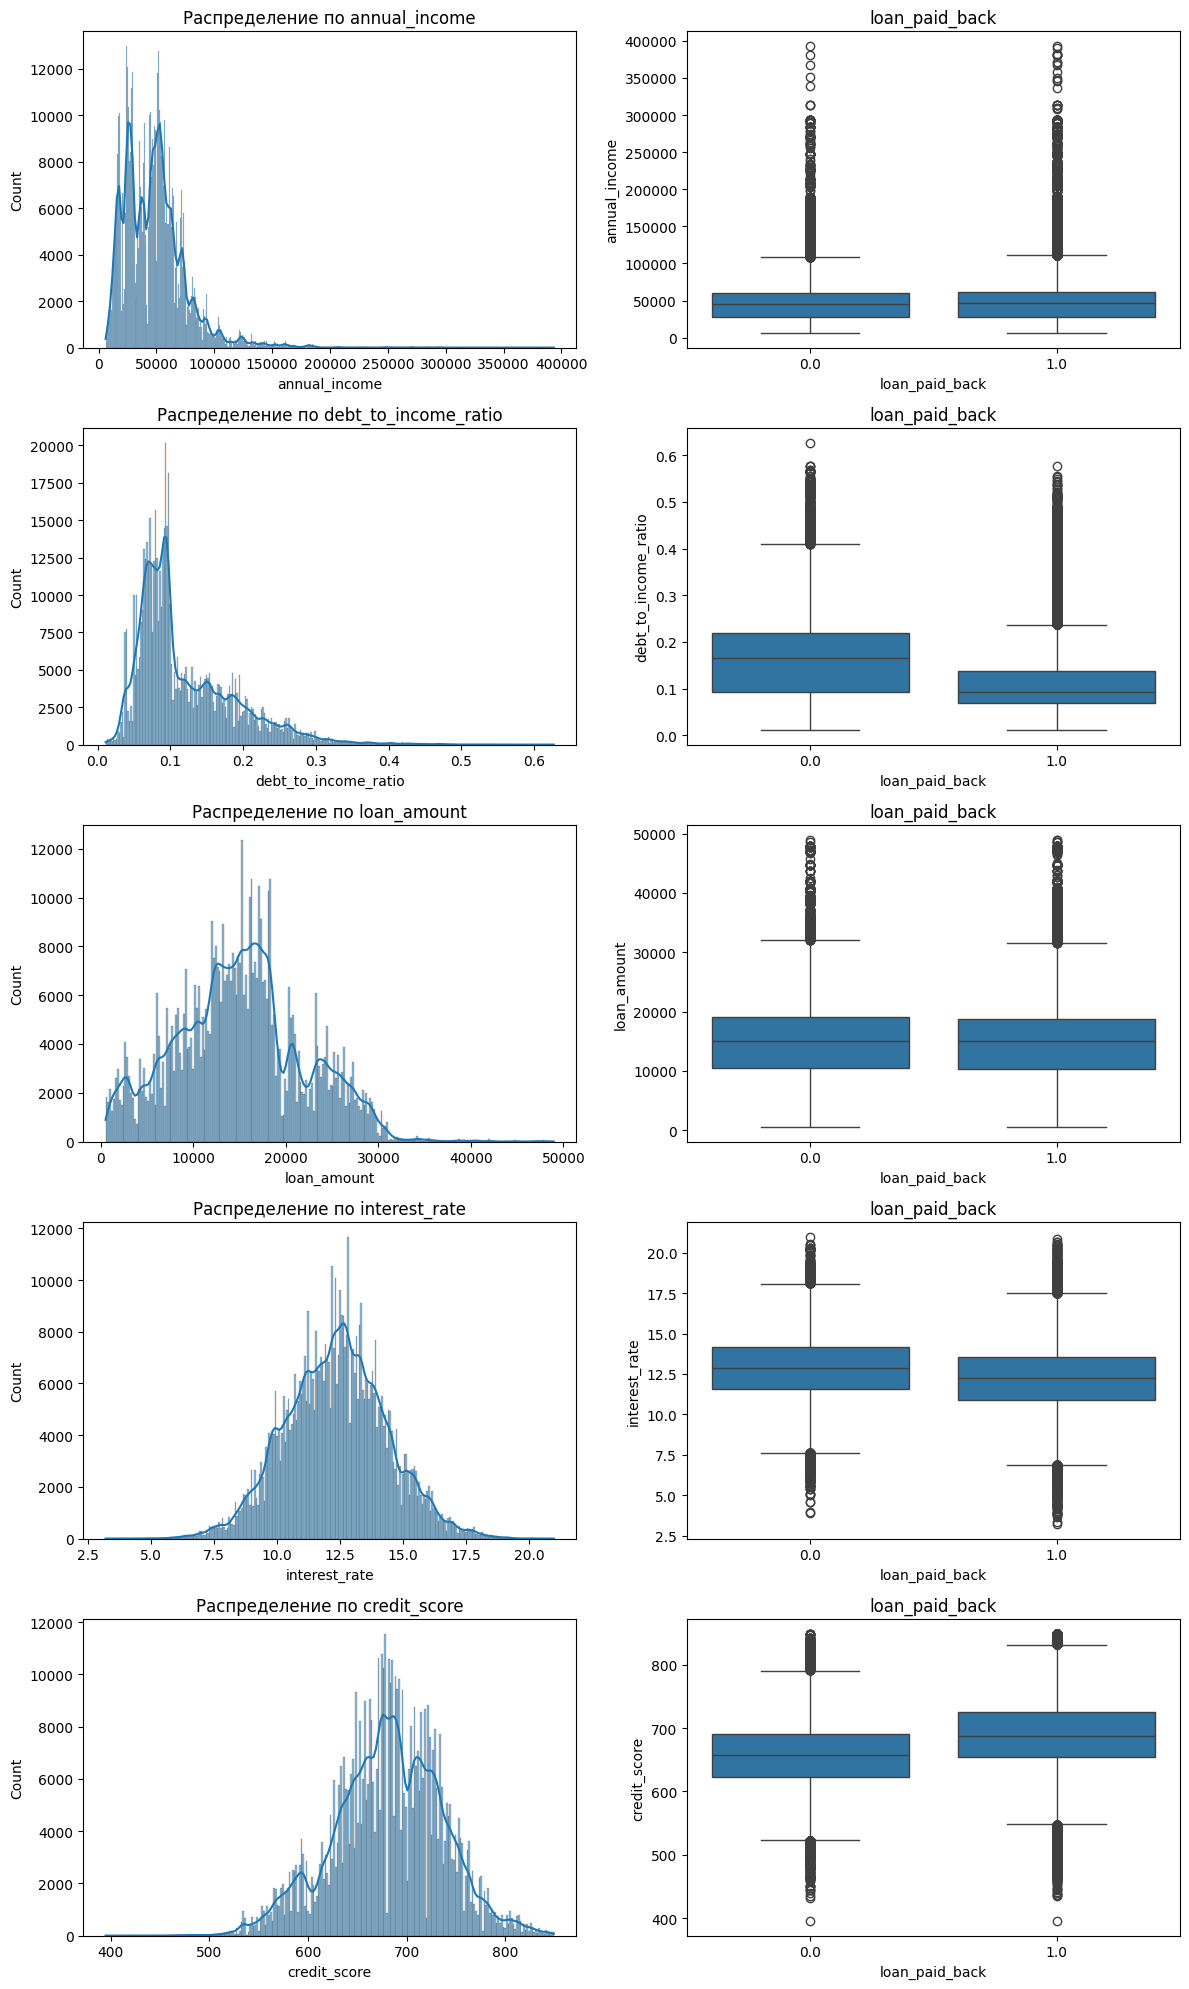

In [22]:
# Гистограмма для числовых значений
fig, axes = plt.subplots(len(numeric_cols), 2, figsize = (12, 4 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Распределение по {col}')

    sns.boxplot(x = df['loan_paid_back'], y=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} vs {df['loan_paid_back']}')
    axes[i, 1].set_title(target)

plt.tight_layout()
plt.show()


In [33]:
def analyze_categorical_risk(df, feature, target='loan_paid_back', top_categories=10):
    """
    Анализ риска по категориальным признакам (риск = доля дефолтов)
    """
    # Считаем долю ДЕФОЛТОВ (target = 0)
    default_rates = 1 - df.groupby(feature)[target].mean()
    default_rates = default_rates.sort_values(ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Общее распределение категорий
    value_counts = df[feature].value_counts().head(top_categories)
    axes[0,0].bar(range(len(value_counts)), value_counts.values, color='lightblue')
    axes[0,0].set_title(f'Распределение {feature} (топ-{top_categories})')
    axes[0,0].set_xticks(range(len(value_counts)))
    axes[0,0].set_xticklabels(value_counts.index, rotation=45)
    axes[0,0].set_ylabel('Количество')
    
    # 2. Доля ДЕФОЛТОВ по категориям (РИСК)
    axes[0,1].bar(range(len(default_rates.head(top_categories))), 
                 default_rates.head(top_categories).values, color='red')
    axes[0,1].set_title(f'РИСК ДЕФОЛТА по {feature}')
    axes[0,1].set_xticks(range(len(default_rates.head(top_categories))))
    axes[0,1].set_xticklabels(default_rates.head(top_categories).index, rotation=45)
    axes[0,1].set_ylabel('Доля дефолтов')
    axes[0,1].axhline(y=1-df[target].mean(), color='black', linestyle='--', 
                     label=f'Средний риск: {(1-df[target].mean()):.2%}')
    axes[0,1].legend()
    
    # 3. Heatmap с распределением
    pivot_data = df[df[feature].isin(value_counts.index[:8])]
    crosstab = pd.crosstab(pivot_data[feature], pivot_data[target], normalize='index')
    sns.heatmap(crosstab, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=axes[1,0])
    axes[1,0].set_title(f'Распределение по {feature}\n(0=дефолт, 1=погашен)')
    
    # 4. Связь с кредитным scoring
    if 'credit_score' in df.columns:
        sns.boxplot(data=df[df[feature].isin(value_counts.index[:8])], 
                   x=feature, y='credit_score', ax=axes[1,1])
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].set_title(f'Credit Score по категориям {feature}')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистики
    print(f"\n=== АНАЛИЗ РИСКА {feature.upper()} ===")
    print(f"Общий уровень дефолтов: {(1-df[target].mean()):.2%}")
    print(f"Топ-5 самых рискованных категорий:")
    for i, (category, risk) in enumerate(default_rates.head().items(), 1):
        print(f"{i}. {category}: {risk:.2%} (в {(risk/(1-df[target].mean())-1):.1%} выше среднего)")
    
    return default_rates


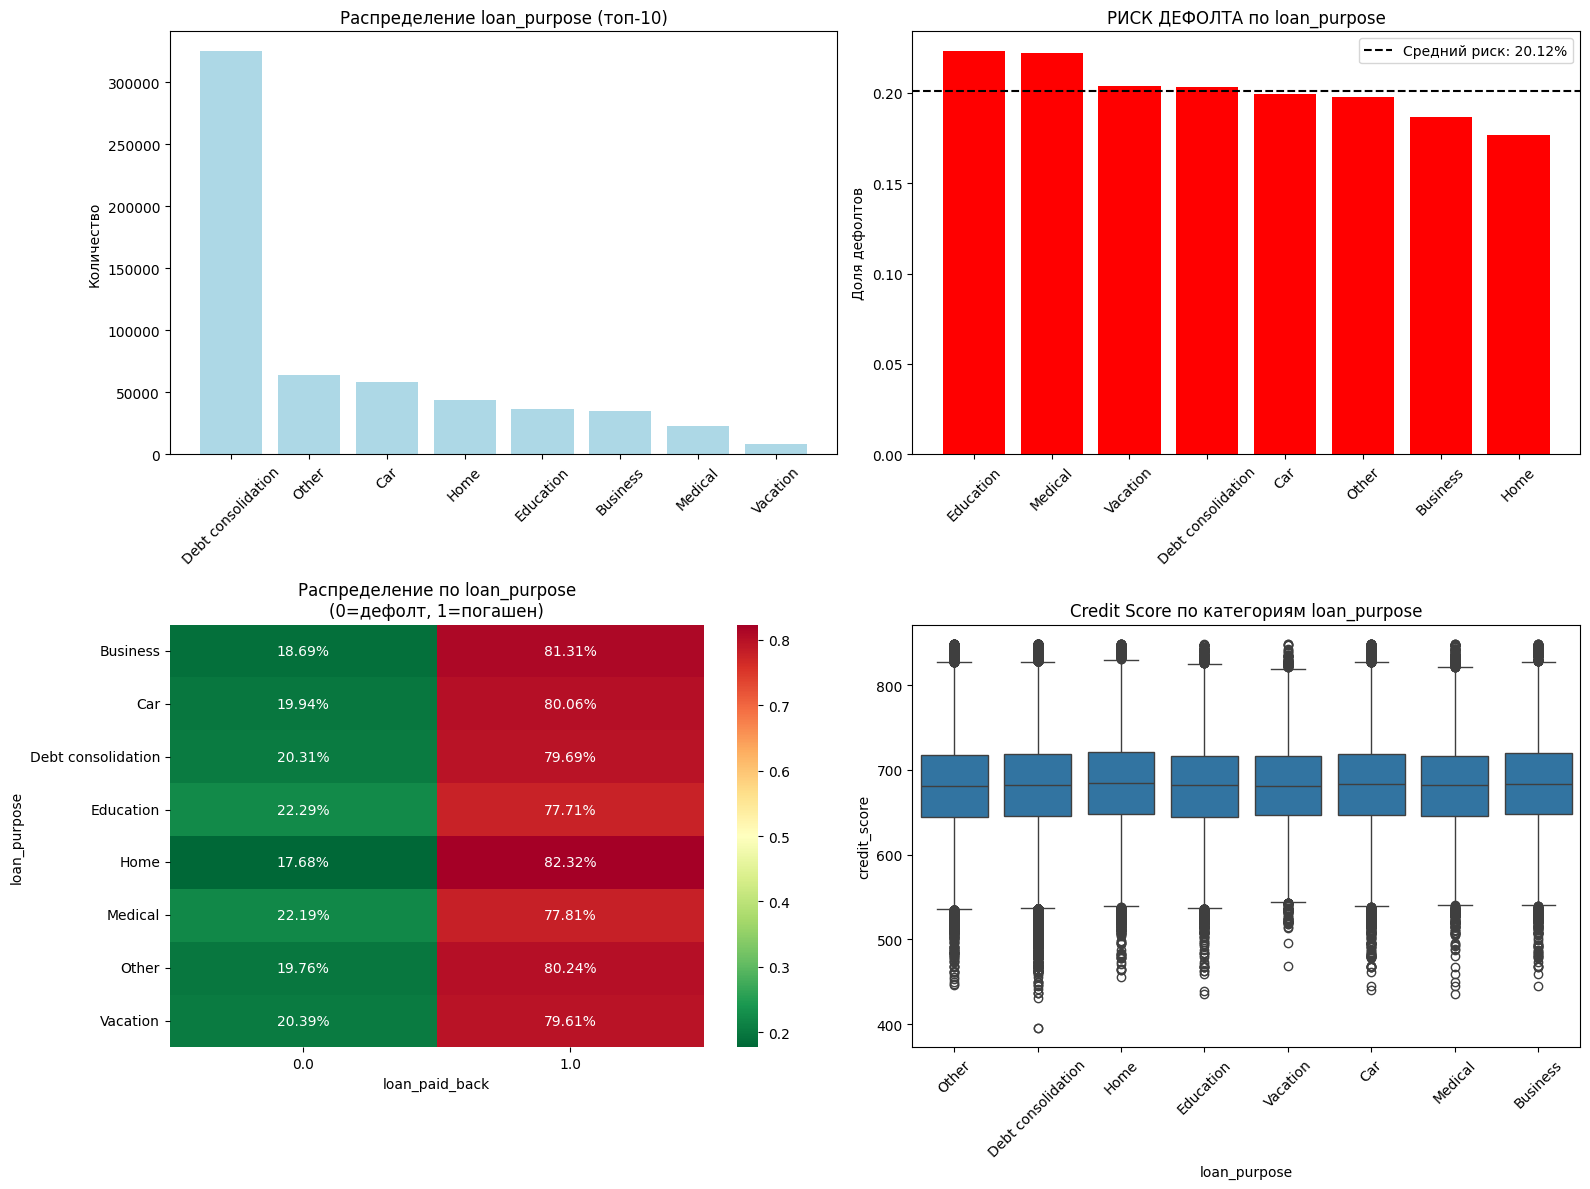


=== АНАЛИЗ РИСКА LOAN_PURPOSE ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. Education: 22.29% (в 10.8% выше среднего)
2. Medical: 22.19% (в 10.3% выше среднего)
3. Vacation: 20.39% (в 1.4% выше среднего)
4. Debt consolidation: 20.31% (в 0.9% выше среднего)
5. Car: 19.94% (в -0.9% выше среднего)


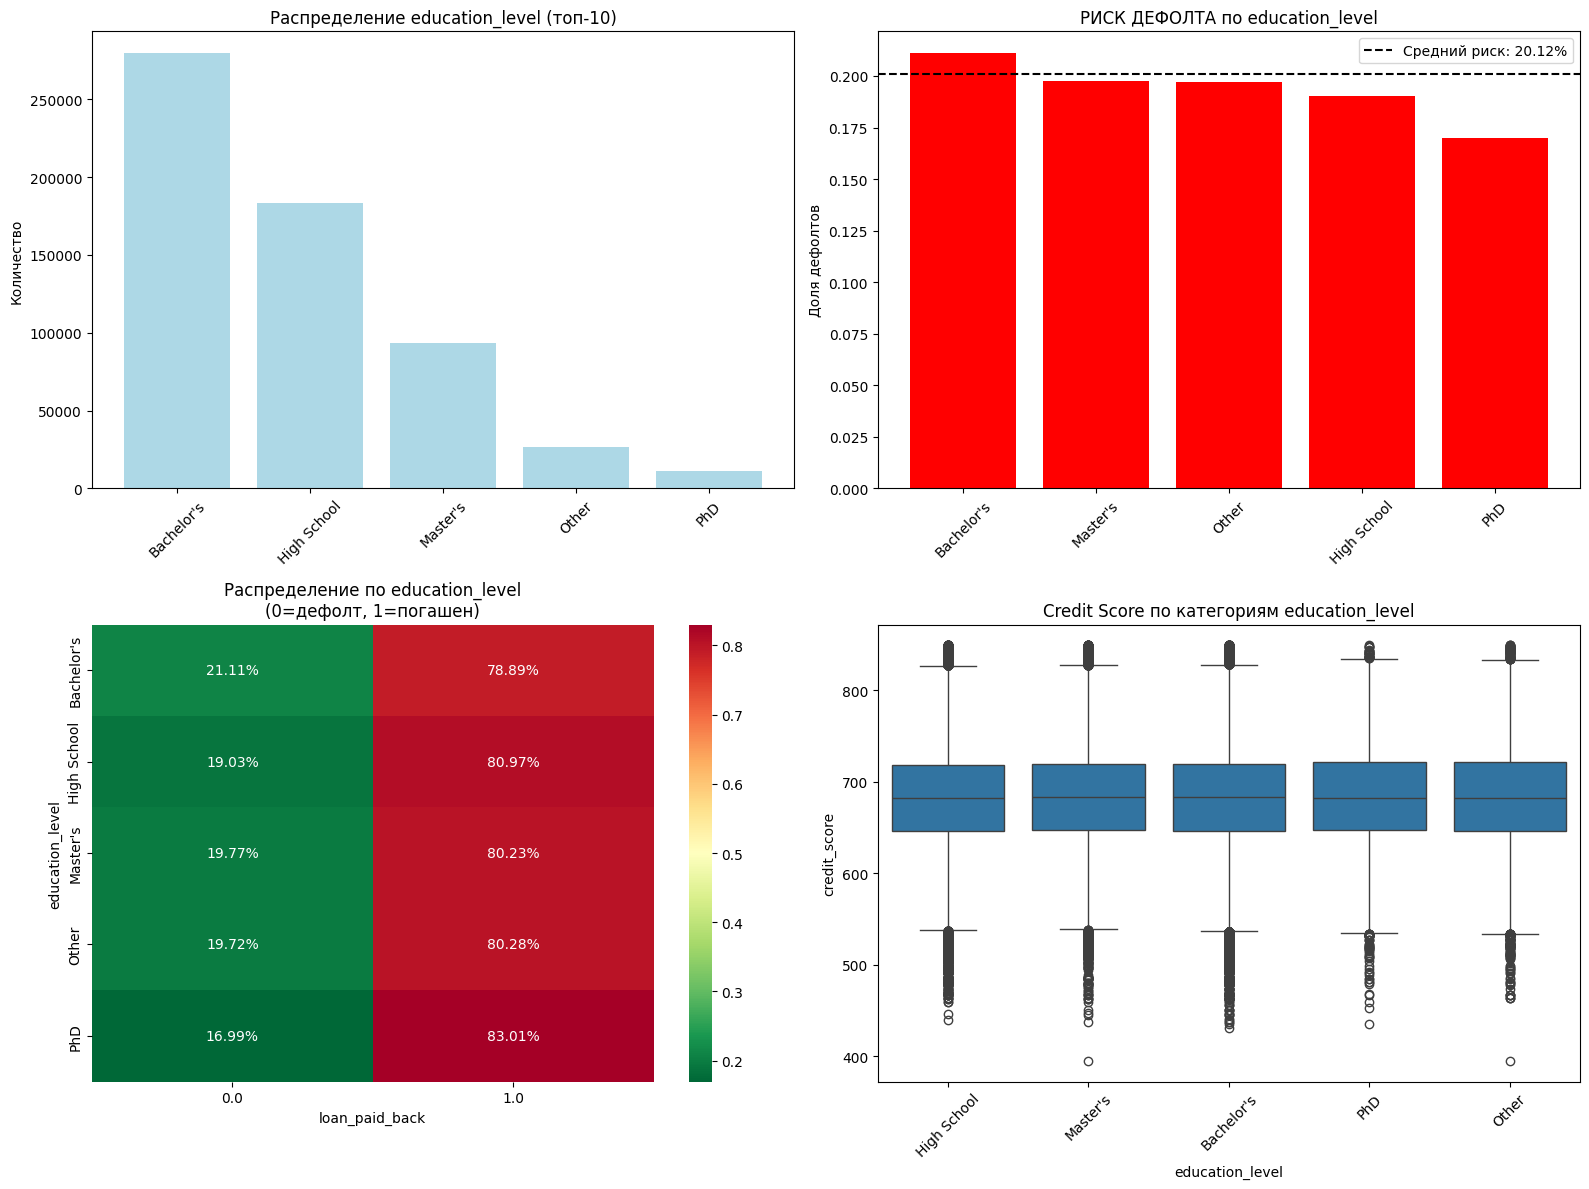


=== АНАЛИЗ РИСКА EDUCATION_LEVEL ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. Bachelor's: 21.11% (в 4.9% выше среднего)
2. Master's: 19.77% (в -1.8% выше среднего)
3. Other: 19.72% (в -2.0% выше среднего)
4. High School: 19.03% (в -5.4% выше среднего)
5. PhD: 16.99% (в -15.5% выше среднего)


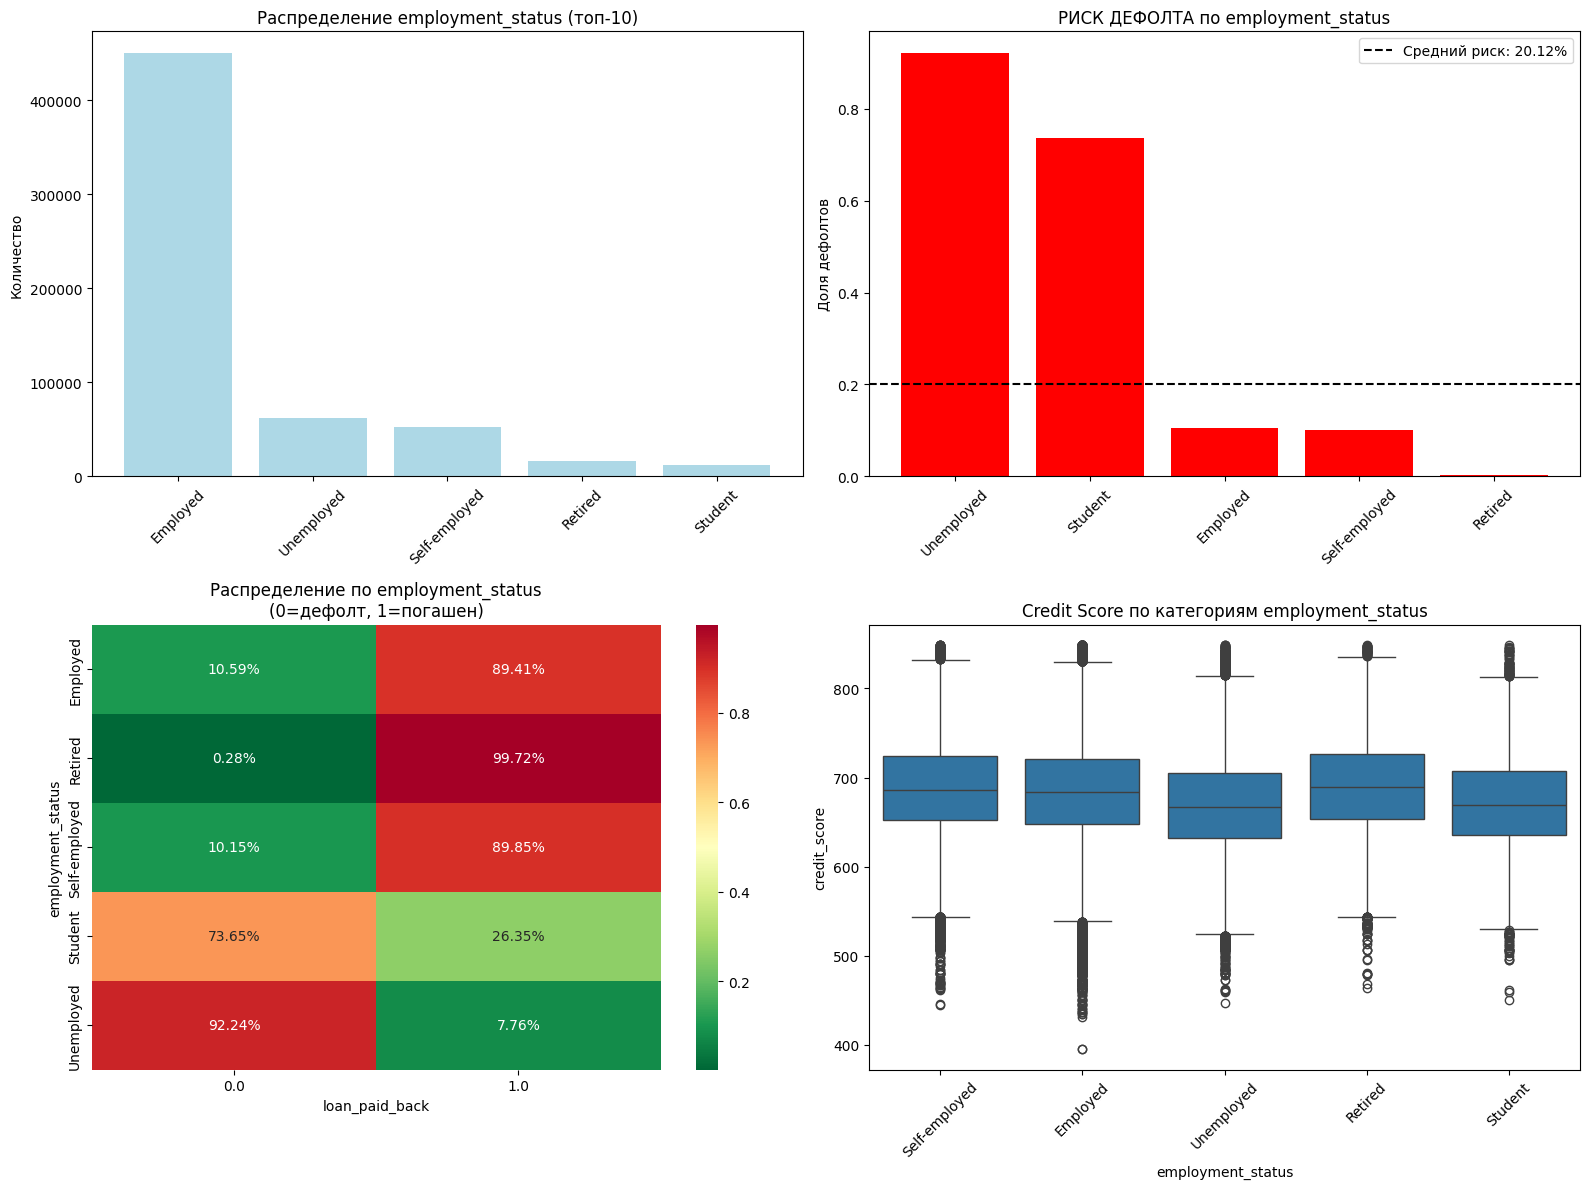


=== АНАЛИЗ РИСКА EMPLOYMENT_STATUS ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. Unemployed: 92.24% (в 358.5% выше среднего)
2. Student: 73.65% (в 266.1% выше среднего)
3. Employed: 10.59% (в -47.4% выше среднего)
4. Self-employed: 10.15% (в -49.5% выше среднего)
5. Retired: 0.28% (в -98.6% выше среднего)


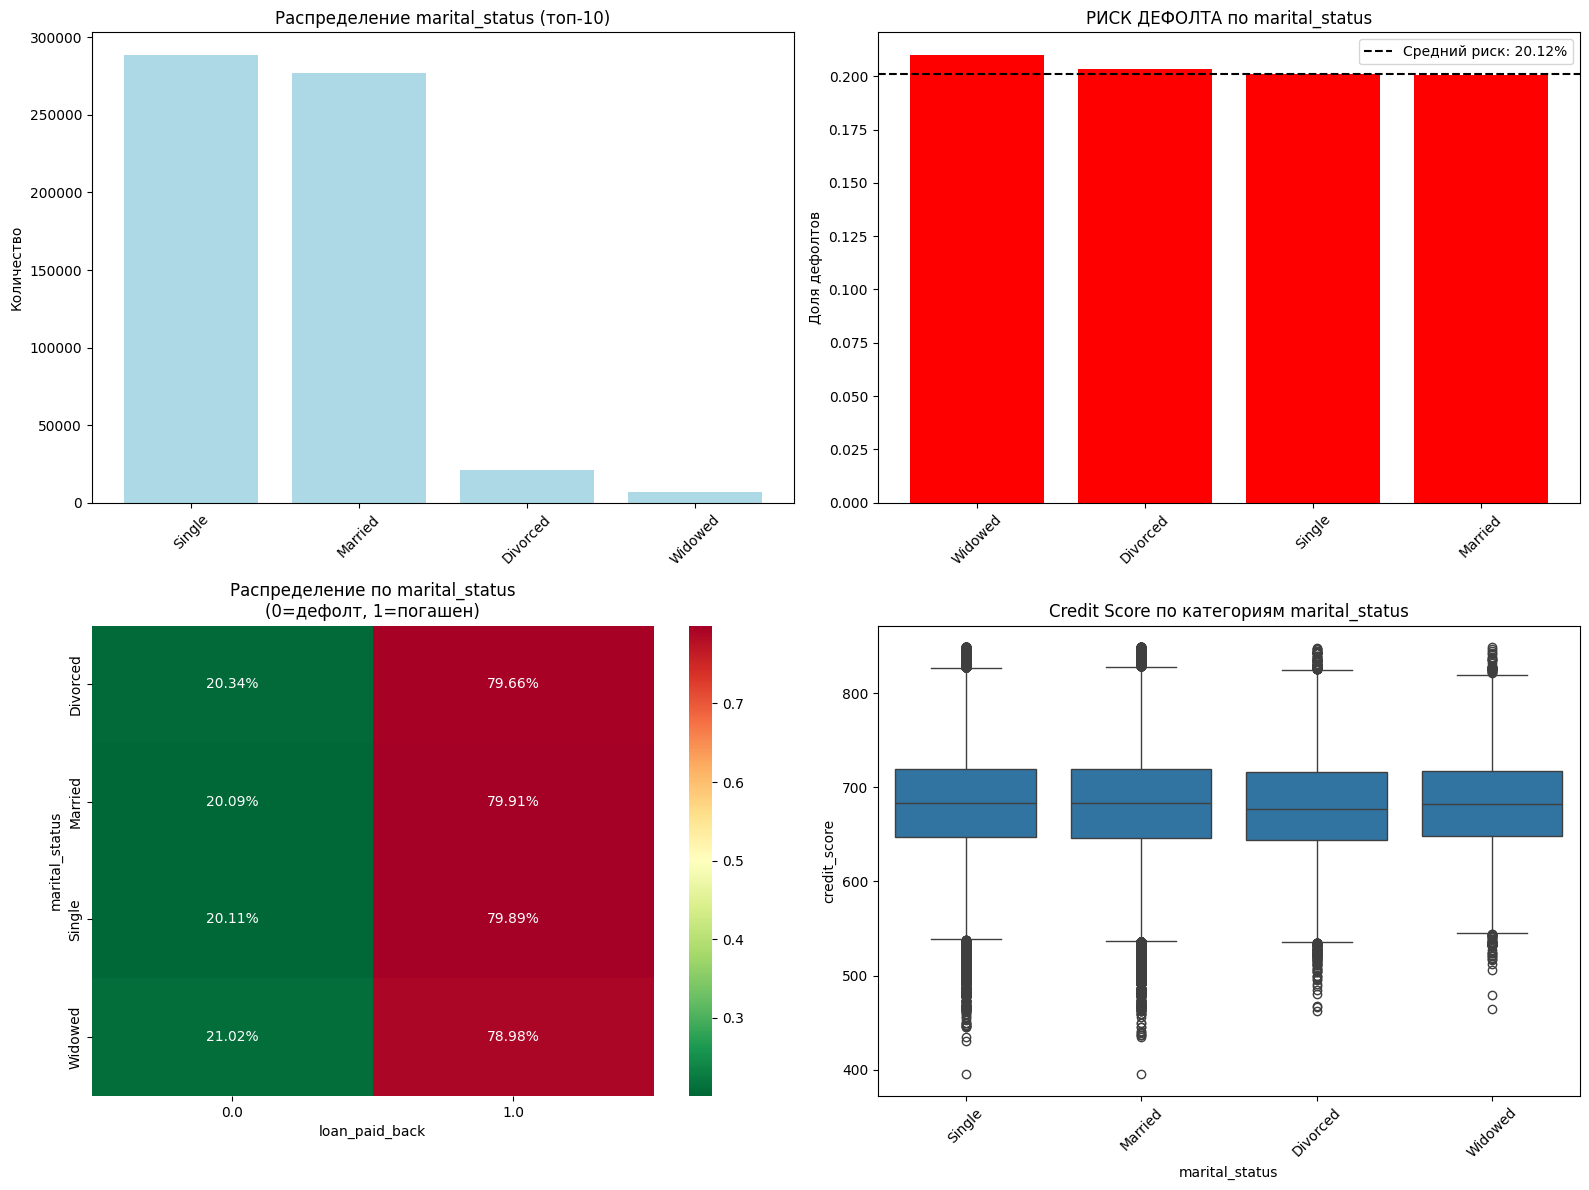


=== АНАЛИЗ РИСКА MARITAL_STATUS ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. Widowed: 21.02% (в 4.5% выше среднего)
2. Divorced: 20.34% (в 1.1% выше среднего)
3. Single: 20.11% (в -0.0% выше среднего)
4. Married: 20.09% (в -0.2% выше среднего)


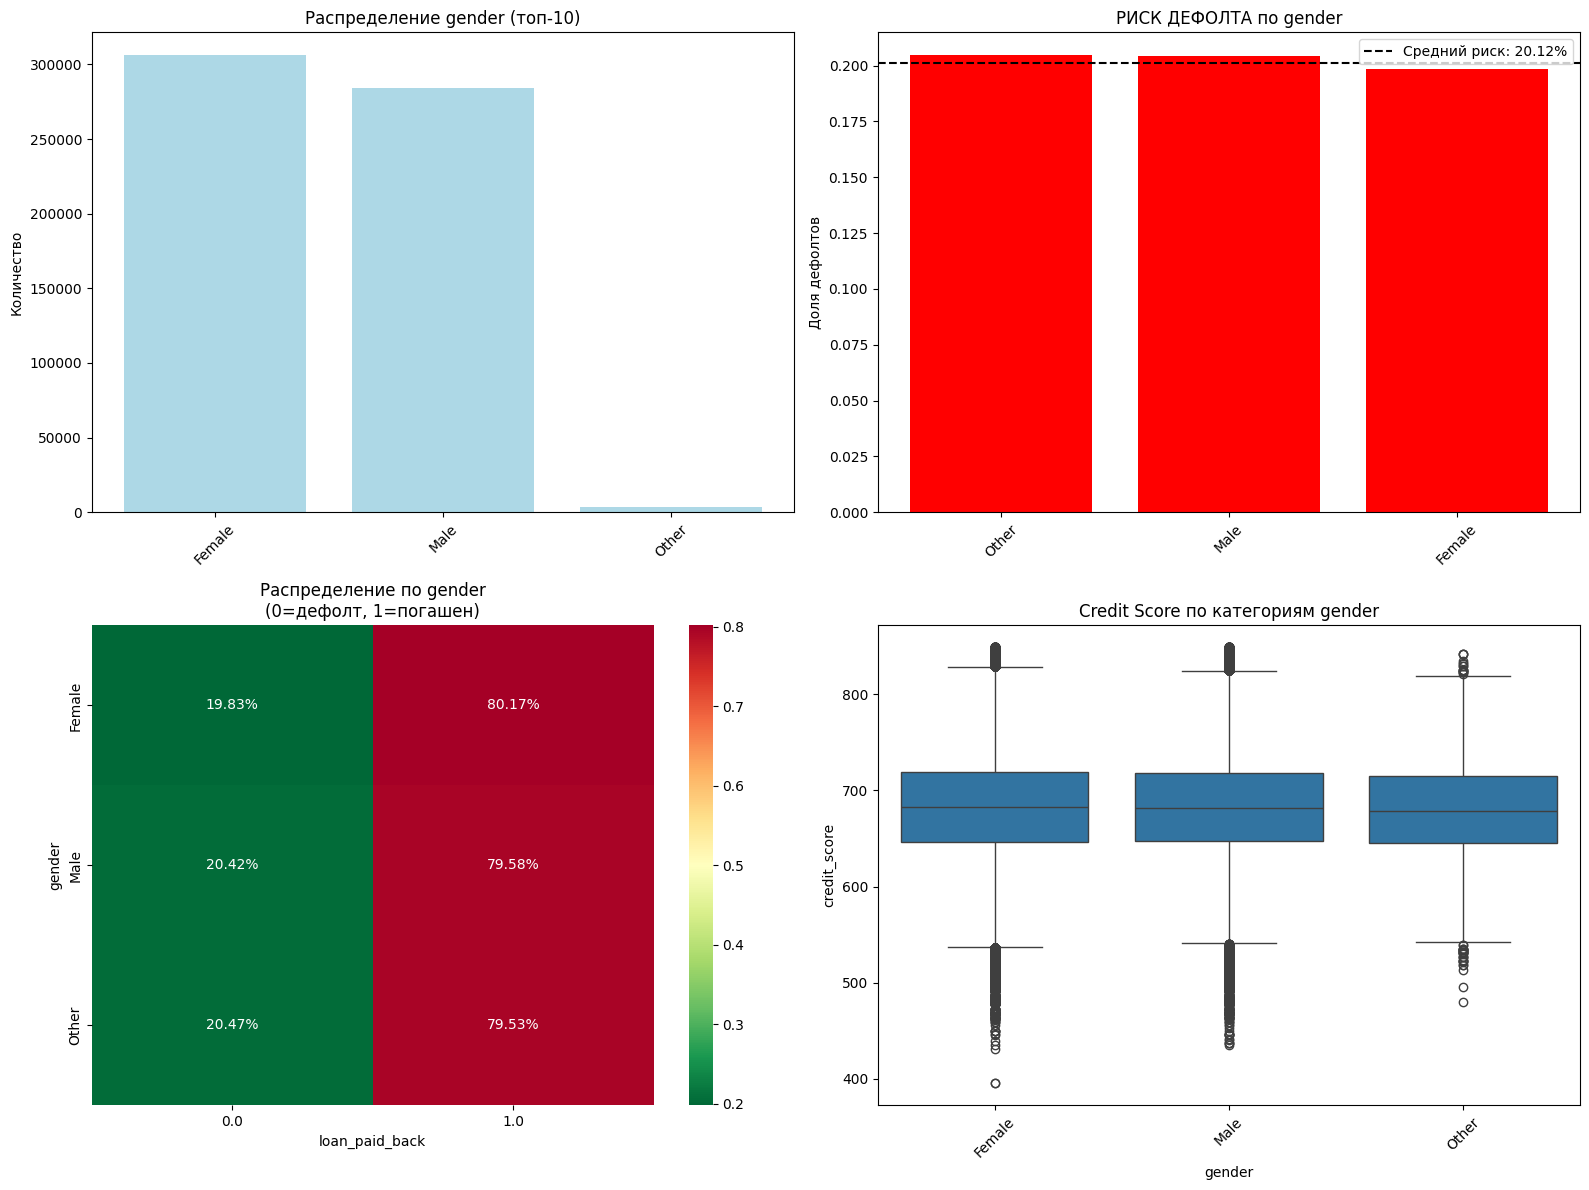


=== АНАЛИЗ РИСКА GENDER ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. Other: 20.47% (в 1.7% выше среднего)
2. Male: 20.42% (в 1.5% выше среднего)
3. Female: 19.83% (в -1.4% выше среднего)


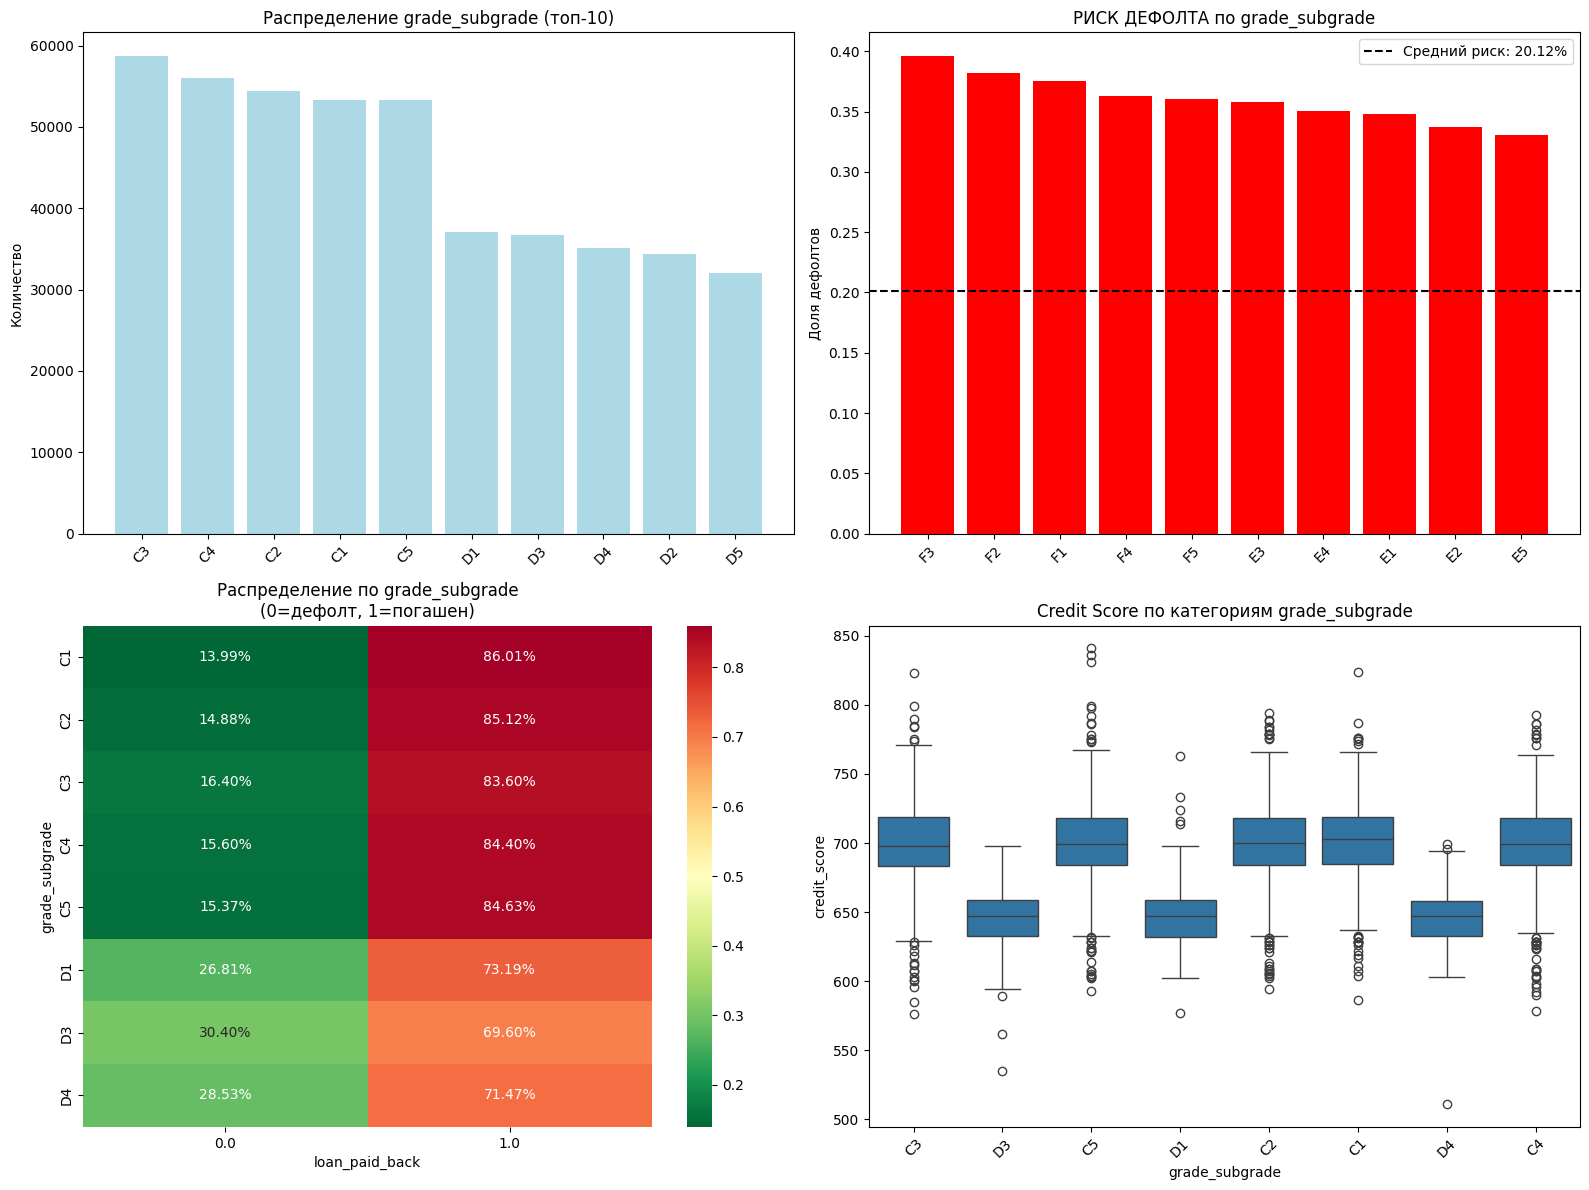


=== АНАЛИЗ РИСКА GRADE_SUBGRADE ===
Общий уровень дефолтов: 20.12%
Топ-5 самых рискованных категорий:
1. F3: 39.59% (в 96.8% выше среднего)
2. F2: 38.23% (в 90.0% выше среднего)
3. F1: 37.55% (в 86.6% выше среднего)
4. F4: 36.30% (в 80.4% выше среднего)
5. F5: 36.07% (в 79.3% выше среднего)


In [35]:
# Анализ цели кредита
loan_purpose_rates = analyze_categorical_risk(df, 'loan_purpose')

# Анализ уровня образования
education_rates = analyze_categorical_risk(df, 'education_level')

# Анализ статуса занятости
employment_rates = analyze_categorical_risk(df, 'employment_status')

# Анализ семейного положения
marital_rates = analyze_categorical_risk(df, 'marital_status')

# Анализ пола
gender_rates = analyze_categorical_risk(df, 'gender')

# Анализ кредитного грейда (это может быть очень важным!)
grade_rates = analyze_categorical_risk(df, 'grade_subgrade')